# 🎯 Milestone 1: Data Collection, Exploration, and Preprocessing  

📌 Section 1: Setup & Mount Google Drive


In [1]:
#!pip install opencv-python rasterio albumentations matplotlib tqdm scikit-learn

In [2]:
# ✅ Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# ✅ Step 2: Import Required Libraries
import os
import cv2
import rasterio
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
from sklearn.preprocessing import LabelEncoder


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


📌 Section 2: Define Paths & Dataset Parameters

In [6]:
# ✅ Define Dataset Paths
dataset_path = "/content/drive/My Drive/EuroSAT"
final_dataset_path = "/content/drive/My Drive/EuroSAT_Final_Dataset"

# ✅ Create the Final Dataset Folder
os.makedirs(final_dataset_path, exist_ok=True)

# ✅ Set Image Properties
IMAGE_SIZE = (64, 64)   # Resize images to 64x64 pixels

# ✅ Select Specific Bands (B2, B3, B4, B8)
BANDS = [1, 2, 3, 7]  # Sentinel-2 index starts from 0 (so B2=1, B3=2, B4=3, B8=7)

TARGET_COUNT = 4000  # Ensure each category has 4,000 images


Get a sample image to check available bands

In [7]:
sample_image_path = None

for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith(".tif"):
            sample_image_path = os.path.join(root, file)
            break
    if sample_image_path:
        break

if sample_image_path:
    with rasterio.open(sample_image_path) as src:
        num_bands = src.count
        print(f"✅ Sample Image: {sample_image_path}")
        print(f"📡 Number of Spectral Bands: {num_bands}")
        print(f"📊 Band Names: {src.descriptions}")
else:
    print("❌ No images found in the dataset!")

✅ Sample Image: /content/drive/My Drive/EuroSAT/AnnualCrop/AnnualCrop_2002.tif
📡 Number of Spectral Bands: 13
📊 Band Names: (None, None, None, None, None, None, None, None, None, None, None, None, None)


Load & Display an Image ✅ Load a sample image and check its properties.

In [8]:


# Dictionary to store one image path per land type
selected_images = {}

# Iterate through each land type folder and pick one image
for land_type in os.listdir(dataset_path):
    land_type_path = os.path.join(dataset_path, land_type)

    if os.path.isdir(land_type_path):  # Check if it's a folder
        for filename in os.listdir(land_type_path):
            if filename.endswith(".tif"):  # Only select .tif images
                selected_images[land_type] = os.path.join(land_type_path, filename)
                break  # Stop after selecting the first image

# Print selected images
for land_type, image_path in selected_images.items():
    print(f"✅ Selected {land_type}: {image_path}")

# Pick one example land type
example_land_type = list(selected_images.keys())[0]  # First land type
example_image_path = selected_images[example_land_type]

# Load the image
with rasterio.open(example_image_path) as src:
    image = src.read()

print(f"✅ Loaded {example_land_type} image with shape: {image.shape}")  # (Bands, Height, Width)


✅ Selected AnnualCrop: /content/drive/My Drive/EuroSAT/AnnualCrop/AnnualCrop_2002.tif
✅ Selected Pasture: /content/drive/My Drive/EuroSAT/Pasture/Pasture_998.tif
✅ Selected Residential: /content/drive/My Drive/EuroSAT/Residential/Residential_1999.tif
✅ Selected Forest: /content/drive/My Drive/EuroSAT/Forest/Forest_2009.tif
✅ Selected Industrial: /content/drive/My Drive/EuroSAT/Industrial/Industrial_1514.tif
✅ Selected SeaLake: /content/drive/My Drive/EuroSAT/SeaLake/SeaLake_2002.tif
✅ Selected River: /content/drive/My Drive/EuroSAT/River/River_1500.tif
✅ Selected PermanentCrop: /content/drive/My Drive/EuroSAT/PermanentCrop/PermanentCrop_1503.tif
✅ Selected HerbaceousVegetation: /content/drive/My Drive/EuroSAT/HerbaceousVegetation/HerbaceousVegetation_2005.tif
✅ Selected Highway: /content/drive/My Drive/EuroSAT/Highway/Highway_1500.tif
✅ Loaded AnnualCrop image with shape: (13, 64, 64)


Visualize Spectral Bands ✅ Display individual bands (e.g., RGB & Near-Infrared) for analysis.

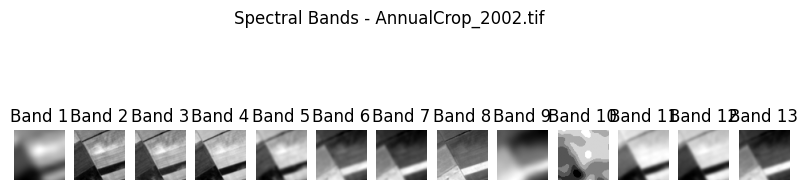

In [9]:
import matplotlib.pyplot as plt

def plot_bands(image, filename):
    plt.figure(figsize=(10, 3))
    for i in range(image.shape[0]):  # Loop through bands
        plt.subplot(1, image.shape[0], i+1)
        plt.imshow(image[i], cmap='gray')
        plt.title(f"Band {i+1}")
        plt.axis("off")
    plt.suptitle(f"Spectral Bands - {filename}")
    plt.show()

# Plot bands for the selected image
plot_bands(image, os.path.basename(example_image_path))


Display the no. of imgs per each category

<ipython-input-10-af38f613afda>:26: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


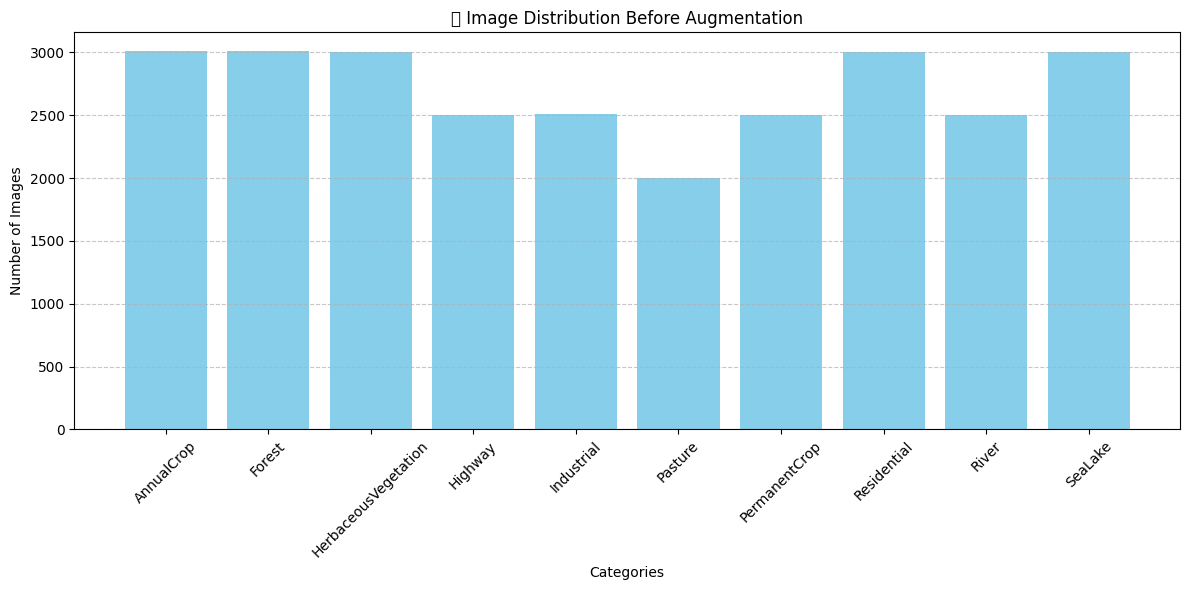

In [10]:
# ✅ Count Images Per Category (Before Augmentation)
categories = sorted(os.listdir(dataset_path))  # Get category names
category_counts = {}

for category in categories:
    category_folder = os.path.join(dataset_path, category)
    if os.path.isdir(category_folder):
        category_counts[category] = len([file for file in os.listdir(category_folder) if file.endswith(".tif")])

# ✅ Convert Counts to Lists for Plotting
category_names = list(category_counts.keys())
image_counts = list(category_counts.values())

# ✅ Plot Image Distribution Before Augmentation
plt.figure(figsize=(12, 6))
plt.bar(category_names, image_counts, color="skyblue")

# ✅ Add Labels & Titles
plt.xlabel("Categories")
plt.ylabel("Number of Images")
plt.title("📊 Image Distribution Before Augmentation")
plt.xticks(rotation=45)  # Rotate category names for readability
plt.grid(axis="y", linestyle="--", alpha=0.7)

# ✅ Show Plot
plt.tight_layout()
plt.show()


📌 Section 3: Define Image Processing & Augmentation

In [11]:
# ✅ Define Image Processing Function
def process_tiff_image(image_path):
    """
    Loads a TIFF image using rasterio, extracts all bands,
    resizes the image, and normalizes pixel values to [0, 1].
    """
    try:
        with rasterio.open(image_path) as src:
            image = src.read(BANDS)  # Load all 13 bands
            image = np.transpose(image, (1, 2, 0))  # Rearrange to (H, W, C)
            image = cv2.resize(image, IMAGE_SIZE)  # Resize
            image = image / 65535.0  # Normalize (Sentinel-2 max value is 65535)
        return image
    except Exception as e:
        print(f"❌ Error processing {image_path}: {e}")
        return None

# ✅ Define Augmentation Pipeline
augmentation = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussianBlur(p=0.3),
])


📌 Section 4: Load, Process & Augment Images

In [12]:
# ✅ Load, Process, and Augment Images
X, y = [], []
category_counts = {}

print("🔄 Processing TIFF Images from EuroSAT...")
for category in tqdm(sorted(os.listdir(dataset_path))):
    category_path = os.path.join(dataset_path, category)

    if os.path.isdir(category_path):
        images = []
        for file in os.listdir(category_path):
            if file.lower().endswith(".tif"):
                image_path = os.path.join(category_path, file)
                img = process_tiff_image(image_path)
                if img is not None:
                    images.append(img)
                    X.append(img)
                    y.append(category)

        # ✅ Apply Augmentation Until Each Category Has 4,000 Images
        current_count = len(images)
        category_counts[category] = current_count
        print(f"📊 Found {current_count} images in {category}.")

        if current_count < TARGET_COUNT:
            i = 0  # Augmentation index
            while current_count < TARGET_COUNT:
                image = images[i % len(images)]  # Cycle through images
                augmented = augmentation(image=image)  # Apply augmentation
                X.append(augmented["image"])
                y.append(category)

                current_count += 1
                i += 1

            print(f"✅ Augmented {category} to {TARGET_COUNT} images!")

# ✅ Convert to NumPy Arrays
X = np.array(X)
y = np.array(y)

print(f"\n✅ Total Processed Images: {X.shape[0]}")


🔄 Processing TIFF Images from EuroSAT...


  0%|          | 0/10 [00:00<?, ?it/s]

📊 Found 3010 images in AnnualCrop.


 10%|█         | 1/10 [05:46<51:54, 346.09s/it]

✅ Augmented AnnualCrop to 4000 images!
📊 Found 3010 images in Forest.


 20%|██        | 2/10 [11:30<46:03, 345.38s/it]

✅ Augmented Forest to 4000 images!
📊 Found 3000 images in HerbaceousVegetation.


 30%|███       | 3/10 [17:12<40:06, 343.78s/it]

✅ Augmented HerbaceousVegetation to 4000 images!
📊 Found 2500 images in Highway.


 40%|████      | 4/10 [21:15<30:22, 303.81s/it]

✅ Augmented Highway to 4000 images!
📊 Found 2510 images in Industrial.


 50%|█████     | 5/10 [25:11<23:16, 279.26s/it]

✅ Augmented Industrial to 4000 images!
📊 Found 2000 images in Pasture.


 60%|██████    | 6/10 [27:55<16:00, 240.12s/it]

✅ Augmented Pasture to 4000 images!
📊 Found 2500 images in PermanentCrop.


 70%|███████   | 7/10 [31:38<11:43, 234.62s/it]

✅ Augmented PermanentCrop to 4000 images!
📊 Found 3000 images in Residential.


 80%|████████  | 8/10 [37:43<09:12, 276.01s/it]

✅ Augmented Residential to 4000 images!
📊 Found 2500 images in River.


 90%|█████████ | 9/10 [41:38<04:23, 263.36s/it]

✅ Augmented River to 4000 images!
📊 Found 3000 images in SeaLake.


100%|██████████| 10/10 [47:59<00:00, 287.95s/it]

✅ Augmented SeaLake to 4000 images!



✅ Total Processed Images: 40000


Save to be safe from any reprocessing

In [13]:
# ✅ Encode Labels (Convert Category Names to Integers)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
print("\n📜 Label Mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

# ✅ Save the Final Dataset
np.save(os.path.join(final_dataset_path, "X.npy"), X)
np.save(os.path.join(final_dataset_path, "y.npy"), y_encoded)

print("\n✅ Final Dataset Saved Successfully!")
print(f"📂 X.npy (images), y.npy (labels), and NDVI.npy are stored in: {final_dataset_path}")



📜 Label Mapping: {'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}

✅ Final Dataset Saved Successfully!
📂 X.npy (images), y.npy (labels), and NDVI.npy are stored in: /content/drive/My Drive/EuroSAT_Final_Dataset


Image Distribution After Augmentation

<ipython-input-14-54f79b15aaba>:20: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


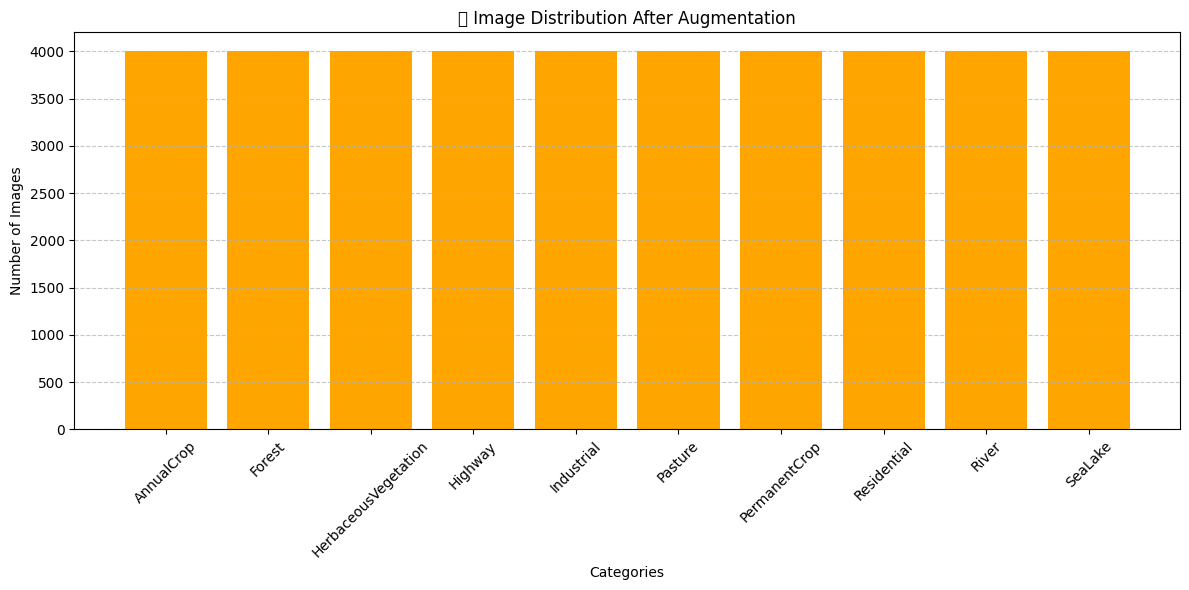

In [14]:
# ✅ Count Images Per Category (After Augmentation)
augmented_category_counts = Counter(y)  # 'y' contains labels after augmentation

# ✅ Convert Counts to Lists for Plotting
category_names = sorted(augmented_category_counts.keys())  # Ensure categories are sorted
image_counts = [augmented_category_counts[cat] for cat in category_names]

# ✅ Plot Image Distribution After Augmentation
plt.figure(figsize=(12, 6))
plt.bar(category_names, image_counts, color="orange")

# ✅ Add Labels & Titles
plt.xlabel("Categories")
plt.ylabel("Number of Images")
plt.title("📊 Image Distribution After Augmentation")
plt.xticks(rotation=45)  # Rotate category names for readability
plt.grid(axis="y", linestyle="--", alpha=0.7)

# ✅ Show Plot
plt.tight_layout()
plt.show()

📌 Section 5: Compute NDVI for one Image

✅ Loaded X.shape: (40000, 64, 64, 4), y.shape: (40000,)

✅ NDVI Computation Completed!
📂 NDVI shape: (40000, 64, 64)

✅ Selected 10 categories for visualization.


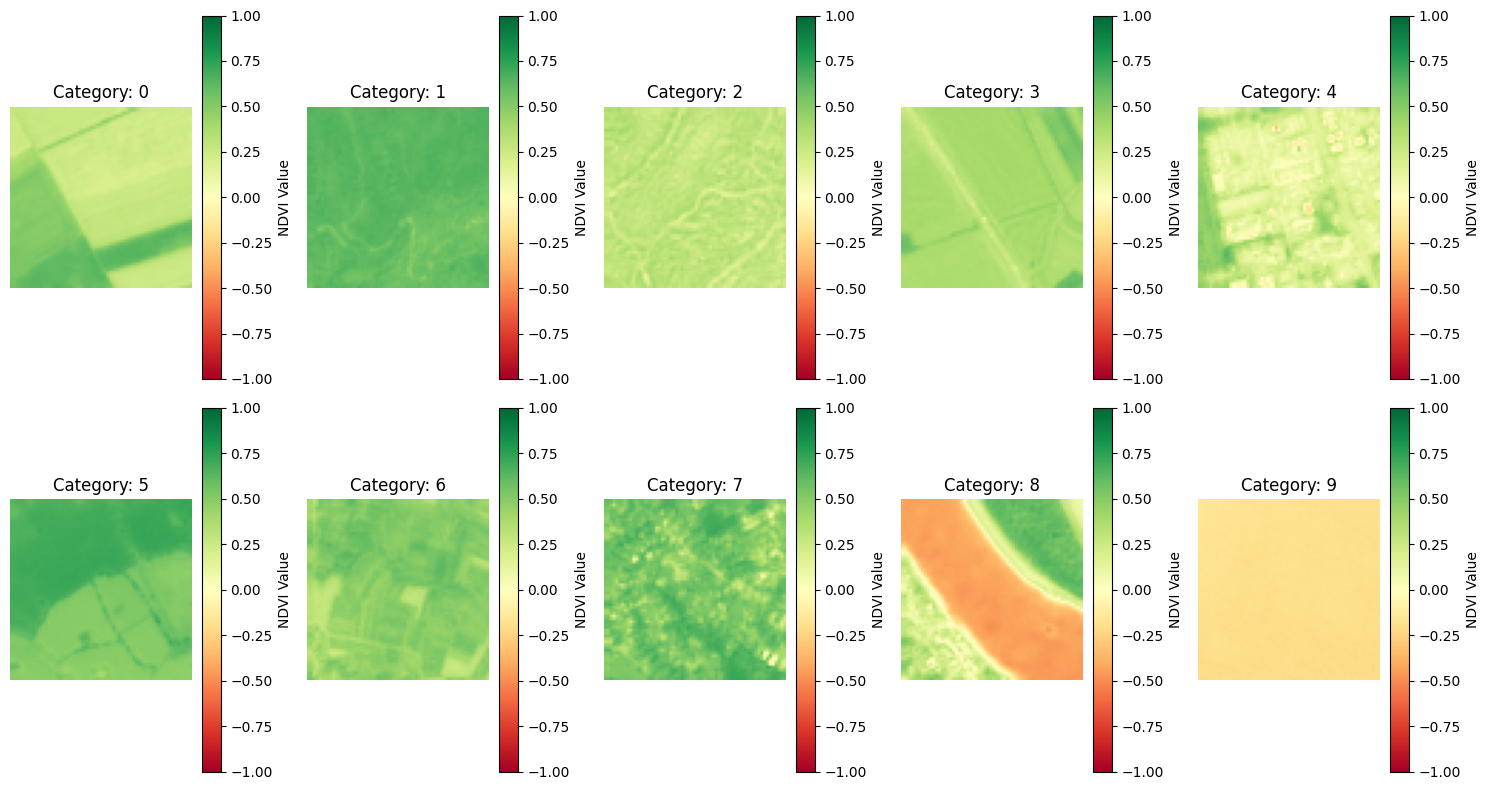

In [5]:
# ✅ Load Data from .npy Files
X = np.load("/content/drive/My Drive/EuroSAT_Final_Dataset/X.npy")  # Load image dataset
y = np.load("/content/drive/My Drive/EuroSAT_Final_Dataset/y.npy")  # Load category labels

print(f"✅ Loaded X.shape: {X.shape}, y.shape: {y.shape}")

# ✅ Define NDVI Computation Function
def compute_ndvi(image, nir_band=3, red_band=2):  # Using B8 (index 3) and B4 (index 2) for NDVI
    """
    Computes NDVI using Near-Infrared (B8) and Red (B4) bands.
    """
    nir = image[:, :, nir_band].astype(float)
    red = image[:, :, red_band].astype(float)
    ndvi = (nir - red) / (nir + red + 1e-5)  # Avoid division by zero
    return ndvi


# ✅ Compute NDVI for the Entire Dataset
ndvi_maps = np.array([compute_ndvi(img) for img in X])

print("\n✅ NDVI Computation Completed!")
print(f"📂 NDVI shape: {ndvi_maps.shape}")

# ✅ Select One Image Per Category for Visualization
category_samples = {}  # Dictionary to store one sample per category

for idx, label in enumerate(y):
    if label not in category_samples:  # Pick only the first occurrence
        category_samples[label] = ndvi_maps[idx]

# ✅ Check that we have one sample per category
print(f"\n✅ Selected {len(category_samples)} categories for visualization.")

# ✅ Visualize NDVI Maps (One Per Category)
plt.figure(figsize=(15, 8))
for i, (category, ndvi_map) in enumerate(category_samples.items()):
    plt.subplot(2, 5, i + 1)  # Adjust layout for 10 categories
    plt.imshow(ndvi_map, cmap='RdYlGn', vmin=-1, vmax=1)
    plt.colorbar(label="NDVI Value")
    plt.title(f"Category: {category}")  # Display category name
    plt.axis("off")

plt.tight_layout()
plt.show()


📌 Section 6: Encode Labels & Save Final Dataset

In [9]:
# ✅ Save the Final Dataset

np.save(os.path.join(final_dataset_path, "NDVI.npy"), ndvi_maps)

print(f"Final Dataset Shape: NDVI={ndvi_maps.shape}")


Final Dataset Shape: NDVI=(40000, 64, 64)


# **🚀 Conclusion**
This notebook successfully:
- ✅ Validated dataset integrity
- ✅ Checked image quality & distributions
- ✅ Confirmed the presence of **multispectral bands**
- ✅ Displayed sample images from different categories
- ✅ Preprocessed images (resize, normalize, augment)
- ✅ Computed & visualized NDVI for vegetation analysis

Next Steps:
- **Train a deep learning model** for land classification